In [239]:
"""Notebook settings and imports."""

%load_ext autoreload
%autoreload 2
# %flow mode reactive

import os

from dataclasses import dataclass, field
from typing import Callable, List, Optional, Tuple, Union

import numpy as np
import torch as t

from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from plotly import express as px
from plotly import graph_objects as go
from plotly import io as pio
from rich import print as rprint
from torch import nn, optim
from torch.nn import functional as F
from tqdm.notebook import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [240]:
@dataclass
class CisConfig:
    n_instances: int = 1
    n_feat: int = 2
    n_hidden: int = 4
    act_fn: List[Callable] = field(default_factory=lambda: [F.relu, F.relu])
    #b1: str | Float[t.Tensor, "inst hid"] = field(default_factory=lambda: "0")
    #b2: str | Float[t.Tensor, "inst hid"] = field(default_factory=lambda: "0")
    optimizer: Callable = t.optim.Adam
    fx: Callable = F.relu

    def __post_init__(self):
        """Ensure attribute values are valid."""
        pass

In [241]:
class Lucius(nn.Module):
    """Lucius toy model."""

    W1: Float[t.Tensor, "inst feat hid"]
    W2: Float[t.Tensor, "inst hid feat"]

    def __init__(self, cfg: CisConfig):
        """Initializes model params."""
        super().__init__()
        self.cfg = cfg

        # Model Weights
        self.W1 = nn.Parameter(nn.init.xavier_normal_(t.empty(cfg.n_instances, cfg.n_feat, cfg.n_hidden)))
        self.W2 = nn.Parameter(nn.init.xavier_normal_(t.empty(cfg.n_instances, cfg.n_hidden, cfg.n_feat)))    

    def gen_batch(self, batch_sz: int) -> t.Tensor:
        """Generates a batch of data (sparse feature vals on [-1, 1]) with instances.
        
        Returns:
            Tensor of shape (batch_sz, n_instances, n_feat) with one random activated
            feature per instance.
        """
        # Create zero tensor with instances dimension
        x = t.zeros(batch_sz, self.cfg.n_instances, self.cfg.n_feat)
        
        # Generate random positions for each batch and instance
        active_positions = t.randint(0, self.cfg.n_feat, (batch_sz, self.cfg.n_instances))
        
        # Generate random values between -1 and 1 for each batch and instance
        active_values = t.rand(batch_sz, self.cfg.n_instances) * 2 - 1
        
        # Create index tensors for vectorized assignment
        batch_idx = t.arange(batch_sz).view(-1, 1).expand(-1, self.cfg.n_instances)
        instance_idx = t.arange(self.cfg.n_instances).expand(batch_sz, -1)
        
        # Vectorized assignment using advanced indexing
        x[batch_idx, instance_idx, active_positions] = active_values
        
        return x

    def forward(self, x: Float[t.Tensor, "batch inst feat"]) -> Float[t.Tensor, "batch inst feat"]:
        """Runs a forward pass through model returning the loss."""

        # Hidden layer
        h = einsum(x, self.W1, "batch inst feat, inst feat hid -> batch inst hid")
        h = self.cfg.act_fn[0](h)

        # Output layer
        y = einsum(h, self.W2, "batch inst hid, inst hid feat -> batch inst feat")
        #y = self.cfg.act_fn[1](y + self.b2)

        return y

    def calculate_loss(self,  x: Float[t.Tensor, "batch inst feat"], y: Float[t.Tensor, "batch inst feat"]) -> Float[t.Tensor, ""]:

        y_true = self.cfg.fx(x)
    
        non_zero_mask = (x != 0)
        zero_mask = (x == 0)
        
        y_diff = y[non_zero_mask] - y_true[non_zero_mask]
        
        #loss = 10.0 * t.sigmoid(1e6 * (t.abs(y_diff) - 1e-6))
        loss = t.mean(t.abs(y_diff))
        loss += t.mean(t.abs(y[zero_mask] - y_true[zero_mask]))
        return loss


    def optimize(
        self, optimizer: t.optim.Optimizer, batch_sz: int, steps: int, logging_freq: int
    ):
        """Optimizes the model."""

        losses = []
        pbar = tqdm(range(steps), desc="Training")

        for step in pbar:
            x = self.gen_batch(batch_sz)
            y = self.forward(x)
            optimizer.zero_grad()
            loss = self.calculate_loss(x, y)
            loss.backward()
            optimizer.step()
            # Log progress
            if step % logging_freq == 0 or (step + 1 == steps):
                losses.append(loss.item())
                pbar.set_postfix({"loss": f"{loss.item():.4f}"})

        return losses

In [259]:
n_instances=1
n_feat = 100
n_hidden = 70

config = CisConfig(n_instances=n_instances, n_feat=n_feat, n_hidden=n_hidden)

In [260]:
model = Lucius(config)

In [261]:
batch_sz = 128
steps = 10000
logging_freq = steps // 10

model.optimize(t.optim.Adam(model.parameters()), batch_sz, steps, logging_freq)

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

[0.22439950704574585,
 0.009253209456801414,
 0.006859003100544214,
 0.005761769134551287,
 0.007068790029734373,
 0.007130071520805359,
 0.0049486602656543255,
 0.0055394480004906654,
 0.00574832409620285,
 0.005870936904102564,
 0.00590914860367775]

In [263]:
import random as r
r.random()

tensor([0.6217, 0.3344, 0.4777, 0.4178, 0.2594, 0.1825, 0.1225, 0.3300, 0.5371,
        0.7258, 0.9427, 0.0342, 0.9437, 0.2843, 0.8679, 0.9371, 0.6582, 0.9955,
        0.5656, 0.6207, 0.1689, 0.8581, 0.6692, 0.8995, 0.8025, 0.9593, 0.0919,
        0.8663, 0.2226, 0.8613, 0.3235, 0.2961, 0.6153, 0.7863, 0.8048, 0.4150,
        0.8756, 0.5560, 0.8780, 0.5418, 0.2986, 0.0720, 0.3464, 0.1740, 0.0493,
        0.9701, 0.2828, 0.1343, 0.0797, 0.3135, 0.6838, 0.8308, 0.3867, 0.9771,
        0.5776, 0.7940, 0.5509, 0.6212, 0.3153, 0.0512, 0.8656, 0.1922, 0.1228,
        0.6611, 0.8646, 0.0600, 0.0363, 0.7209, 0.2012, 0.1923, 0.8720, 0.3769,
        0.9679, 0.2200, 0.6802, 0.2392, 0.8649, 0.0627, 0.7800, 0.0291, 0.4212,
        0.2245, 0.8543, 0.4555, 0.2090, 0.4827, 0.2976, 0.4239, 0.1157, 0.8252,
        0.4008, 0.1875, 0.3583, 0.1637, 0.4897, 0.5800, 0.8796, 0.8415, 0.6444,
        0.2137])

In [265]:
#x = t.Tensor([0,0,0,0,1,0,0,0,0,0])
#x = t.Tensor([0,0,1,0,0])
active_ind = np.random.randint(0,n_feat)
print(active_ind)
x = t.zeros(n_feat)
x[active_ind] = 1
x = t.reshape(x, [1,1,x.shape[0]])
with t.no_grad():
    y = model.forward(x)
    print(y)


28
tensor([[[ 5.5424e-03,  6.5290e-03,  6.9864e-03, -5.4959e-03,  2.0349e-02,
           1.1774e-02, -1.6365e-02,  5.3994e-03, -7.7928e-03, -7.6540e-03,
          -4.2519e-04,  5.6442e-03,  4.6678e-03,  2.7748e-02, -1.4718e-02,
          -7.3387e-03,  6.5362e-03,  1.5965e-02, -3.6345e-04, -9.7007e-05,
          -8.4113e-03, -4.4185e-03, -1.6347e-02, -6.1514e-03,  8.4850e-03,
           2.4569e-04,  2.7772e-03, -1.4457e-02,  9.9214e-01,  1.0795e-03,
          -2.3857e-04,  1.5571e-01,  1.6937e-02,  8.7891e-03,  2.7710e-03,
          -4.6021e-03,  9.7028e-03, -2.9599e-03,  8.3238e-03, -9.2188e-03,
          -1.0193e-03,  6.4712e-02, -2.0330e-01,  2.1209e-03, -5.4310e-03,
          -8.9973e-03, -1.5510e-03, -1.5114e-02,  4.8841e-01, -3.6288e-03,
           1.3448e-03, -4.9250e-03, -2.3024e-04,  1.7115e-03,  1.2914e-03,
           3.2908e-03, -1.2554e-03, -4.6199e-03, -3.5234e-03,  1.2457e-03,
          -9.0784e-03, -1.0707e-03, -1.8555e-02, -5.8483e-03,  6.4342e-02,
           5.3379e-03,

In [305]:
count, losses_sep = count_represented_features(n_feat, model, threshold=0.1)
print(count)
print(losses_sep)
print(np.mean(losses_sep))

100
[tensor(0.0209), tensor(0.0189), tensor(0.0390), tensor(0.0196), tensor(0.0154), tensor(0.0189), tensor(0.0194), tensor(0.0162), tensor(0.0238), tensor(0.0314), tensor(0.0119), tensor(0.0262), tensor(0.0320), tensor(0.0180), tensor(0.0189), tensor(0.0271), tensor(0.0236), tensor(0.0275), tensor(0.0132), tensor(0.0130), tensor(0.0124), tensor(0.0231), tensor(0.0326), tensor(0.0295), tensor(0.0152), tensor(0.0224), tensor(0.0196), tensor(0.0458), tensor(0.0196), tensor(0.0141), tensor(0.0150), tensor(0.0136), tensor(0.0228), tensor(0.0332), tensor(0.0250), tensor(0.0372), tensor(0.0222), tensor(0.0117), tensor(0.0124), tensor(0.0232), tensor(0.0169), tensor(0.0295), tensor(0.0224), tensor(0.0204), tensor(0.0242), tensor(0.0143), tensor(0.0140), tensor(0.0315), tensor(0.0146), tensor(0.0318), tensor(0.0129), tensor(0.0305), tensor(0.0217), tensor(0.0201), tensor(0.0209), tensor(0.0152), tensor(0.0160), tensor(0.0326), tensor(0.0177), tensor(0.0218), tensor(0.0171), tensor(0.0140), ten

C:\Users\gigle\AppData\Local\Temp\ipykernel_44352\213167100.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


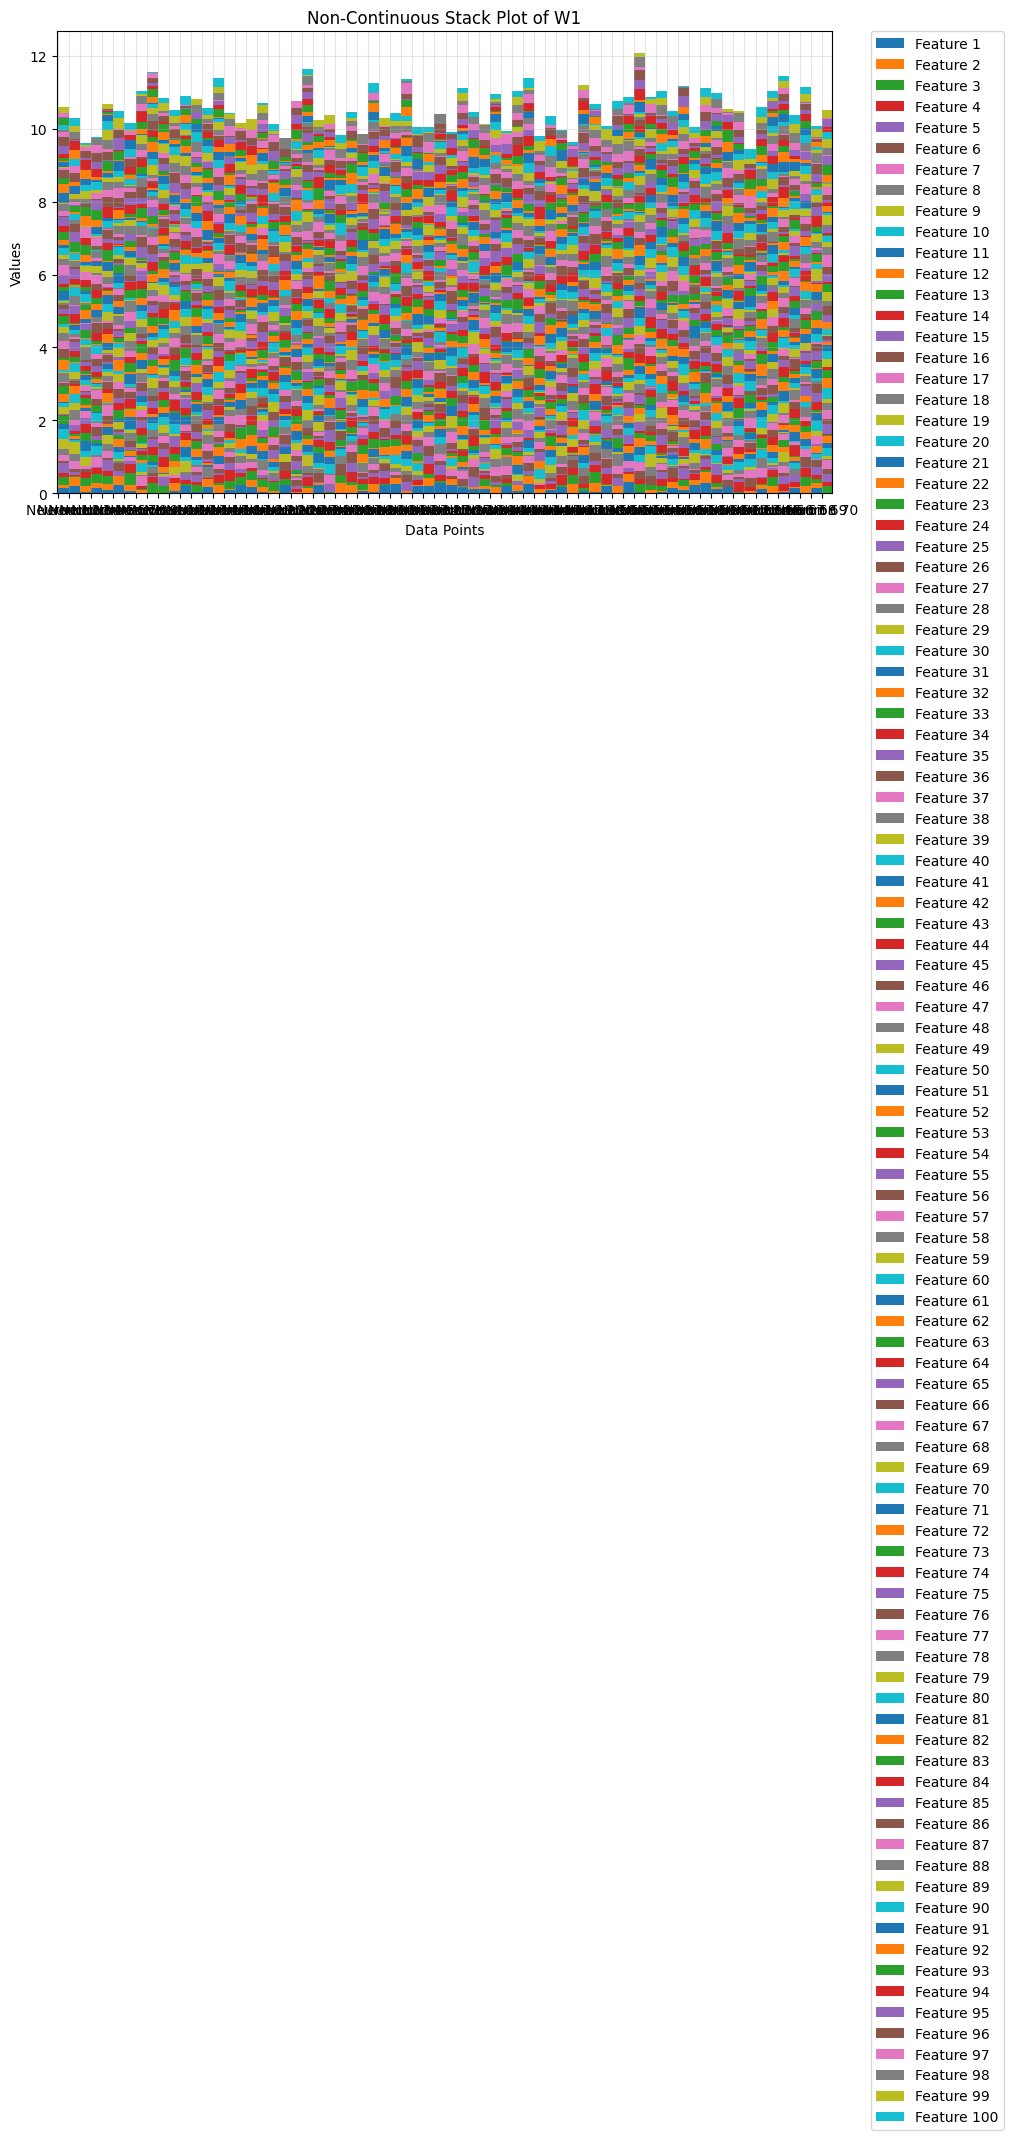

In [306]:
plot_polysemanticity(model.W1.detach().squeeze())

In [301]:
def count_represented_features(n_feat, model, threshold = 0.01) -> int:
    count = 0
    losses_sep = []
    with t.no_grad():
        for i in range(n_feat):
            x = t.zeros(n_feat)
            x[i] = 1
            x = t.reshape(x, [1,1,x.shape[0]])
            y = model.forward(x)
            loss = model.calculate_loss(x,y)
            losses_sep.append(loss)
            #y.squeeze(0).squeeze(0)
            y = y[0][0]
            #print(y.shape)
            if t.abs(y[i] - 1.0).item() < threshold:
                count += 1
        return (count, losses_sep)

In [186]:
def plot_polysemanticity(W1):
    import matplotlib.pyplot as plt

    # Define the weight matrix
    #W1 = model.W1.detach().numpy().squeeze()
    W1 = threshold_matrix(W1)

    # Create feature labels
    features = [f'Feature {i+1}' for i in range(W1.shape[0])]

    # Extend x range by one point to show the last step
    x = np.arange(W1.shape[1] + 1)
    # Extend the weight matrix data by repeating the last column
    W1_extended = np.hstack([W1, W1[:, -1:]])

    # Create larger figure
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create stack plot with extended data
    ax.stackplot(x, W1_extended, labels=features, step='post')
    ax.set_xlim(-0.1, W1.shape[1] - 0.1)  # Set limit to show exactly 6 stacks

    # Enhance visibility
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

    # Set titles and labels
    ax.set_title('Non-Continuous Stack Plot of W1')
    ax.set_xlabel('Data Points')
    ax.set_ylabel('Values')

    # Add x-ticks for each neuron
    ax.set_xticks(np.arange(W1.shape[1]))
    ax.set_xticklabels([f'Neuron {i+1}' for i in range(W1.shape[1])])

    # Adjust layout to prevent cutoff
    plt.tight_layout()

    # Show the plot
    plt.show()

In [187]:
def threshold_matrix(matrix, threshold=0.01):
    """
    Sets matrix elements to zero if their absolute value is below the threshold.
    
    Args:
        matrix: Input numpy array
        threshold: Values below this threshold will be set to 0 (default: 1e-10)
    
    Returns:
        numpy array with small values set to zero
    """
    # Create a copy to avoid modifying the original matrix
    result = np.copy(matrix)
    
    # Set elements below threshold to zero
    result[np.abs(result) < threshold] = 0
    
    return result